<a href="https://colab.research.google.com/github/yuvalofek/Deep_Learning/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Neural Algorithm of Artistic Style

Base Model: VGG-Network
  19 layers - 16 conv layers, 6 maxpool used (no fully connected layers)
  used avg pool instead of maxpool for better results


Style and content images are inputs
Use the values of the first 5 convolution filters (conv1_1 to conv5_1) in subsets. 

Style Image used in the paper "Composition VII by Wassily Kandinsky"

Also have a ratio of the content to style

Content Loss - Squared error bw original and generated:

$L_{content} = \frac{1}{2}\sum{F_{i,j} - P_{i,j}}^2$ for each layer

Style Loss - Gram matrix: $\sum{F_{i,k}F_{j,k}}$ over k, for each layer l

Then $E^l = \frac{1}{4N_l^2M_l^2}\sum{(G_{ij}^l - A_{ij}^l)^2}$
and the loss is:

$L_{style} = \sum{w_lE_l}$

Finally, the total loss is calculated as 
$L_{total} = \alpha L_{content}+\beta L_{style}$


**The plan:**

It seems that the plan is to run the style image in the model, get style layer values. Then run the content image through the model to get the content layer values. 

Finally we run noise through the model and use the values that we got earlier to penalize the system until the output ends up being what we want. 



**References:**


https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b - chosing an optimizer

keras API stuff - a lot of different things

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf - Understanding Style Transfer

Andrew Ng YouTube - understanding what's happening

Ernesto Colon - We spoke a bit about some of the bugs we were having and how we solved them. 






#Imports

In [ ]:
import tensorflow as tf
import numpy as np

#plots
import matplotlib.pyplot as plt

#image
import matplotlib.image as mpimg
import logging


#Prepping Input Images

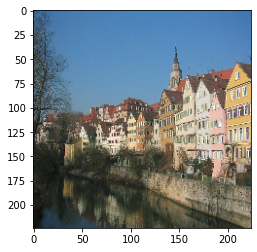

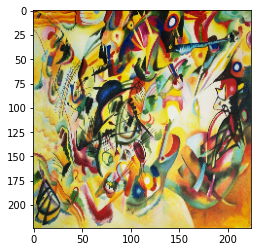

In [ ]:
content=mpimg.imread('content.jpg')
content = cv2.resize(content, (224,224))

plt.imshow(content)
plt.show()

style = mpimg.imread('compVII.jpg')
style = cv2.resize(style, (224,224))
plt.imshow(style)
plt.show()

content = content.reshape(1, 224, 224, 3)/255
style = style.reshape(1, 224, 224, 3)/255

#Model to Extract Layer Feature Maps

In [ ]:
### VGG Model
#From the VGG paper and the reference to 19 layers, I assume that my paper
#refered to ConvNet Configuration E from the VGG paper (on page 3)
#(https://arxiv.org/pdf/1409.1556.pdf):

#Input is 224x224x3 (RGB)

#Used the keras VGG19 because it was pretrained 
#Since the loss is given the outputs of certain layers, I make a model whose 
#outputs are the layers I care about
def layer_model(layer_weights):
  mod = tf.keras.applications.VGG19(
      input_shape = (224,224,3),
      include_top=False,
      weights='imagenet')
  mod.trainable = False
  layers = [mod.get_layer(index = idx).output for idx,_ in layer_weights]
  return tf.keras.Model(mod.input, layers)


#Class for Style Transfer


In [ ]:
class styleNet:
  def __init__ (self,  content, style, style_weights, 
                ratio, initialize = 'random', seed = None):
    tf.random.set_seed(seed)

    self.style_weights = style_weights 
    self.ratio = ratio
    self.shape = (1,224,224,3)
    self.model = layer_model(style_weights)

    #Initialize input noise
    if initialize == 'content':
      self.img = tf.Variable(content.reshape(224,224,3))
    elif initialize == 'style':
      self.img = tf.Variable(style.reshape(224,224,3))
    else: 
      self.img = tf.Variable(tf.random.uniform((224,224,3), 0,1))
    
    #Get content Value
    p = self.model(content)  
    self.F = tf.reshape(tf.transpose(p[0],perm = [0, 3, 1, 2]),
                        shape= [p[0].shape[-1], p[0].shape[1]*p[0].shape[2]])
    #Get style Values
    a = self.model(style)
    As = []
    for a_i in a:
      #manipulate shape
      a_i = tf.reshape(tf.transpose(a_i,perm = [0, 3, 1, 2]),
                    shape= [a_i.shape[-1], a_i.shape[1]*a_i.shape[2]])
      #gram Matrix
      A_i = tf.matmul(a_i,tf.transpose(a_i))
      As.append(A_i)
    self.As = As

  ###Losses
  ###Content:
  def L_content(self,x):
    #We are getting something shape (1, width, height, num_channels)
    #That means we need to change the shape
    G = tf.reshape(tf.transpose(x,perm = [0, 3, 1, 2]),
                  shape= [x.shape[-1], x.shape[1]*x.shape[2]])
    #Loss
    L_c = tf.reduce_sum((self.F-G)**2)/2
    return L_c

  ### Style
  def L_style(self, layer_list_x):
    def L_style_per_layer(A, x): 
      #reshape to proper shape
      x = tf.reshape(tf.transpose(x,perm = [0, 3, 1, 2]),
                    shape= [x.shape[-1], x.shape[1]*x.shape[2]])
      #Gram matrices
      G = tf.matmul(x,tf.transpose(x))

      #return the loss
      L_s = tf.reduce_mean((G-A)**2)/(4*x.shape[1])
      return L_s

    num_layers = len(layer_list_x)
    L_style = 0
    #Firt layer is actually the input so we skip that
    for i in range(1, num_layers):
      #get layer style loss
      L_style_layer = L_style_per_layer(self.As[i],layer_list_x[i])
      #add weighted value to total style loss
      L_style += L_style_layer*self.style_weights[i][1]
    return L_style

  def loss(self):
    pred = self.model(tf.reshape(self.img, self.shape))
    L_c = self.L_content(pred[0])
    L_s = self.L_style(pred)
    #Keeping magnitude of the alpha+beta the same
    L_t = self.ratio/(1+self.ratio)*L_c+L_s/(1+self.ratio) 
    return L_t

  def step(self, optimizer, cache):
    with tf.GradientTape(persistent=True) as tape: 
      tape.watch(self.img)
      lss = self.loss()
    cache.append(lss)

    #get update paramaters
    grads = tape.gradient(lss, self.img)
    optimizer.apply_gradients(zip([grads], [self.img]))
    #return updated loss cache
    return cache

  def run(self, num_steps, optimizer = tf.optimizers.Adam()):
    cache = []
    for i in range(num_steps):
      cache = self.step(optimizer, cache)
      #Training printout
      if not((i+1)%50):
        p_train = int((i+1)/num_steps*100)
        curr_loss = cache[-1]
        print(f'\r Training completed: {p_train}% |',
              f'Loss: {curr_loss} ',
              end = '')
    return cache

In [ ]:
def print_current_images(styles, style_layers, alpha_beta_ratios):
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)
  
  f, ax = plt.subplots(len(style_layers),len(alpha_beta_ratios), figsize = (17,17))
  f.suptitle('Neural Style Transfer for different style layer subsets and alpha/beta ratios', fontsize=14)

  for i in range(len(style_layers)):
    for k in range(len(alpha_beta_ratios)):
          ax[i, k].imshow(styles[str(i+1)+str(k)].img.numpy())
  for k, r in enumerate(alpha_beta_ratios):
    ax[i,k].set_xlabel('alpha/beta: '+str(r))
  for i, layer_idx in enumerate(style_layers):
    ax[i,0].set_ylabel('style layer subset: '+str(style_layers[:i+1]))
  plt.savefig('StyleTransfer.eps', format='eps')
  plt.show()
  logger.setLevel(old_level)


#Getting The Figure

80142336/80134624 [==============================] - 1s 0us/step
Number of layers: 1 | alpha/beta: 1e-05
 Training completed: 100% | Loss: 1.8196165561676025 
Number of layers: 1 | alpha/beta: 0.0001
 Training completed: 100% | Loss: 8.751914978027344 
Number of layers: 1 | alpha/beta: 0.001
 Training completed: 100% | Loss: 59.70610046386719 
Number of layers: 1 | alpha/beta: 0.01
 Training completed: 100% | Loss: 247.7764892578125 
Number of layers: 2 | alpha/beta: 1e-05
 Training completed: 100% | Loss: 19.478572845458984 
Number of layers: 2 | alpha/beta: 0.0001
 Training completed: 100% | Loss: 155.05746459960938 
Number of layers: 2 | alpha/beta: 0.001
 Training completed: 100% | Loss: 1121.58935546875 
Number of layers: 2 | alpha/beta: 0.01
 Training completed: 100% | Loss: 4540.65087890625 
Number of layers: 3 | alpha/beta: 1e-05
 Training completed: 100% | Loss: 30.972694396972656 
Number of layers: 3 | alpha/beta: 0.0001
 Training completed: 100% | Loss: 188.47262573242188 
N

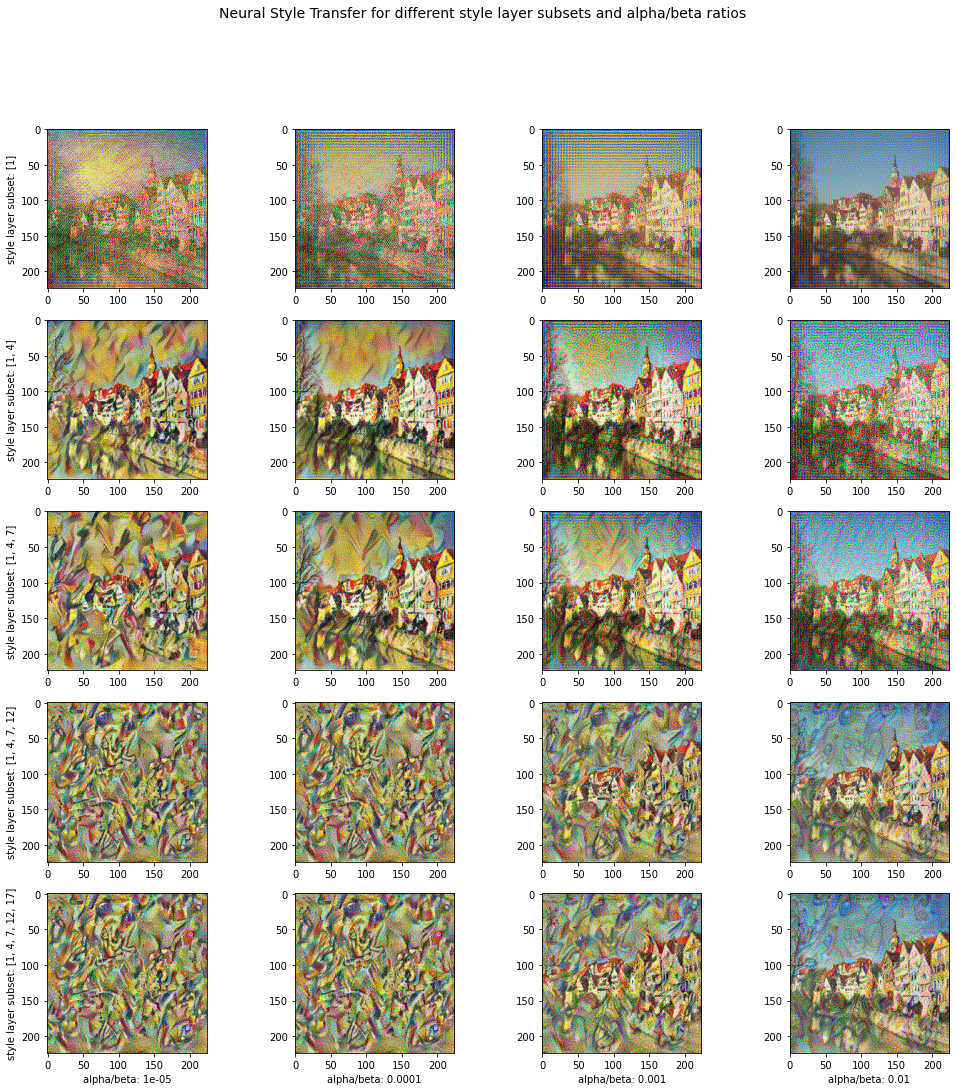

In [ ]:
###Training loops 
N_iter = 20000
content_layer = 4
style_layers = [1, 4, 7, 12,17]
alpha_beta_ratios = [1e-5, 1e-4, 1e-3, 1e-2]


styles = {}
N_layers = len(style_layers)
for i in range(1,N_layers + 1):
  #First layer to extract is the content layer one
  style_weights = [(content_layer,0)]
  #Style Layer Coefficients
  for j in range(1,i+1):
    style_weights.append((style_layers[j-1],1/i))

  for k, r in enumerate(alpha_beta_ratios):
    #initialize the images
    styles[str(i)+str(k)] = styleNet(content, style, style_weights, r, 42)
    #initialize optimizer
    styles[str(i)+str(k)+'opt'] = tf.optimizers.Adam()
    #run the training
    print('Number of layers:', i, '| alpha/beta:', r)
    _ = styles[str(i)+str(k)].run(N_iter,styles[str(i)+str(k)+'opt'])    
    print('')

#print the images
print_current_images(styles, style_layers, alpha_beta_ratios)

Number of layers: 1 | alpha/beta: 1e-05
 Training completed: 100% | Loss: 1.6465880870819092 
Number of layers: 1 | alpha/beta: 0.0001
 Training completed: 100% | Loss: 8.458064079284668 
Number of layers: 1 | alpha/beta: 0.001
 Training completed: 100% | Loss: 59.13817596435547 
Number of layers: 1 | alpha/beta: 0.01
 Training completed: 100% | Loss: 245.92041015625 
Number of layers: 2 | alpha/beta: 1e-05
 Training completed: 100% | Loss: 18.67554473876953 
Number of layers: 2 | alpha/beta: 0.0001
 Training completed: 100% | Loss: 154.13145446777344 
Number of layers: 2 | alpha/beta: 0.001
 Training completed: 100% | Loss: 1117.8916015625 
Number of layers: 2 | alpha/beta: 0.01
 Training completed: 100% | Loss: 4521.8857421875 
Number of layers: 3 | alpha/beta: 1e-05
 Training completed: 100% | Loss: 28.156970977783203 
Number of layers: 3 | alpha/beta: 0.0001
 Training completed: 100% | Loss: 186.74574279785156 
Number of layers: 3 | alpha/beta: 0.001
 Training completed: 100% | Los

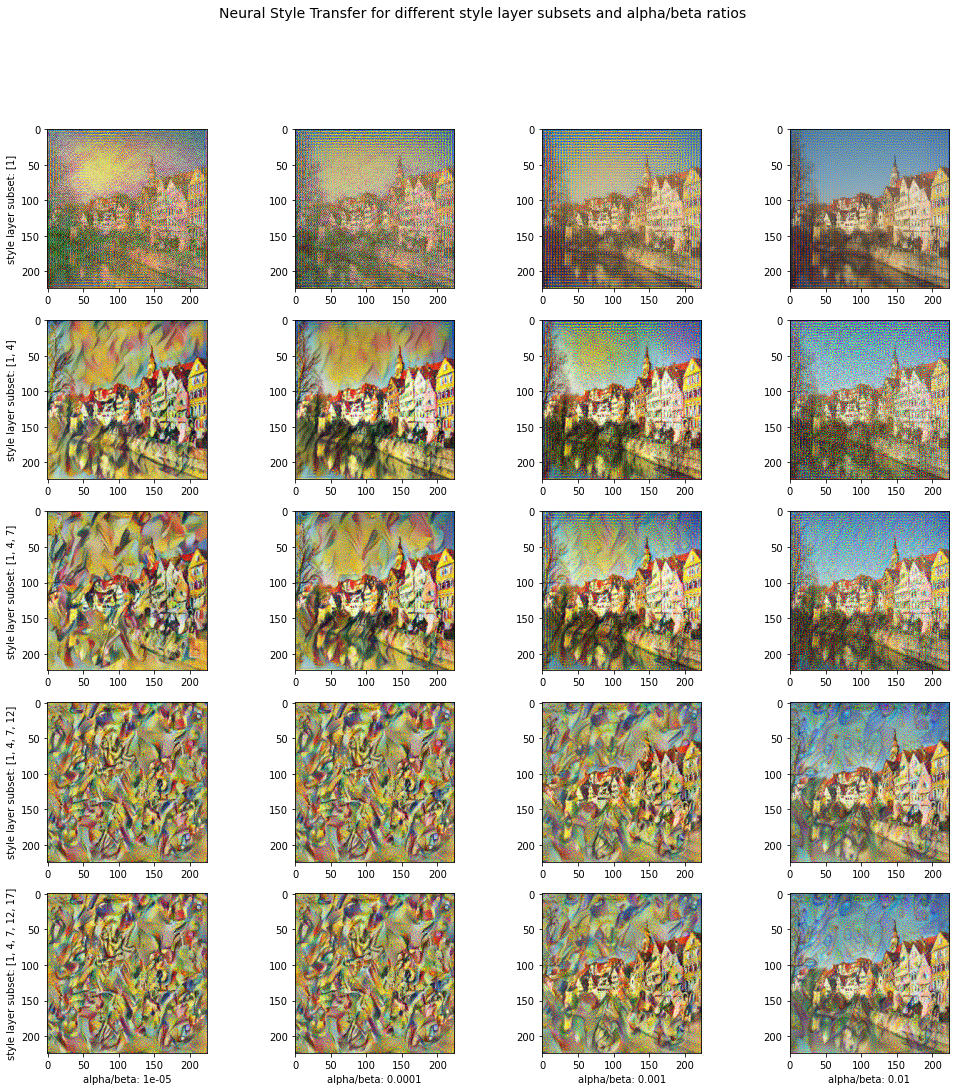

In [ ]:
#Continue to train the images 

N_iter = 1000
for i in range(1,N_layers + 1):
  #First layer to extract is the content layer one
  style_weights = [(conteI nt_layer,0)]
  #Style Layer Coefficients
  for j in range(1,i+1):
    style_weights.append((style_layers[j-1],1/i))

  for k, r in enumerate(alpha_beta_ratios):
    print('Number of layers:', i, '| alpha/beta:', r)
    _ = styles[str(i)+str(k)].run(N_iter, styles[str(i)+str(k)+'opt'])    
    print('')

print('')
print_current_images(styles, style_layers, alpha_beta_ratios)
